In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Loding and Cleaning CSV data

In [23]:
# Load CSV files
species_df = pd.read_csv('species_info.csv')
observations_df = pd.read_csv('observations.csv')

In [24]:
# Display the first five rows to inspect the data
print(species_df.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


In [25]:
print(observations_df.head())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85


We need to Clean park names by removing the 'National Park' substring

In [26]:
observations_df['park_name'] = observations_df['park_name'].str.replace('National Park', '').str.strip()

In [27]:
print(observations_df.head())

            scientific_name              park_name  observations
0        Vicia benghalensis  Great Smoky Mountains            68
1            Neovison vison  Great Smoky Mountains            77
2         Prunus subcordata               Yosemite           138
3      Abutilon theophrasti                  Bryce            84
4  Githopsis specularioides  Great Smoky Mountains            85


## Clean and Organize Conservation Status

Next, let's update the conservation status information in the species dataframe. Since species that aren’t at risk may have missing values (NaN) in the conservation status column, we replace them with "Low Risk". Then, we define an ordered categorical type so that we can sort statuses by risk level later on.

In [28]:
# Replace NaN values with 'Low Risk'
species_df['conservation_status'] = species_df['conservation_status'].fillna('Low Risk')

# Define an order for the conservation statuses based on risk level
status_order = ['Low Risk', 'Species of Concern', 'Threatened', 'Endangered']

# Convert the column to a categorical type with the defined order
species_df['conservation_status'] = pd.Categorical(species_df['conservation_status'],
                                                     categories=status_order,
                                                     ordered=True)

# Verify the changes
print(species_df['conservation_status'].value_counts())


conservation_status
Low Risk              5633
Species of Concern     161
Endangered              16
Threatened              10
Name: count, dtype: int64


## Preparing the Data for Merging

Before merging the datasets, we need to ensure that each species in the species dataframe has a unique record by removing duplicates. In cases where a species appears more than once with different conservation statuses, we keep the record showing the worst status (our categorical ordering is:
Low Risk < Species of Concern < Threatened < Endangered).

In [29]:
# Count duplicate scientific names
duplicate_count = species_df.duplicated(subset='scientific_name').sum()
print("Duplicates found:", duplicate_count)

# Sort the dataframe so that the worst conservation status (i.e., highest risk) comes first.
# Since our categorical order is ascending from Low Risk to Endangered,
# sorting in descending order puts 'Endangered' at the top.
species_df_sorted = species_df.sort_values('conservation_status', ascending=False)

# Drop duplicates, keeping the first (i.e., the worst record) for each species.
species_df_cleaned = species_df_sorted.drop_duplicates(subset='scientific_name', keep='first')

# Verify the number of unique species
print("Unique species:", species_df_cleaned['scientific_name'].nunique())

# Merge the cleaned species data with observations.
# An outer join ensures that all observation records are retained.
combined_df = observations_df.merge(species_df_cleaned, on='scientific_name', how='outer')

# Confirm that the merged dataframe has the same number of rows as the observations dataframe.
print("Length of observations_df:", len(observations_df))
print("Length of combined_df:", len(combined_df))


Duplicates found: 283
Unique species: 5541
Length of observations_df: 23296
Length of combined_df: 23296


# Perform Exploratory Data Analysis (EDA)

Now that our data is merged and cleaned, let's begin exploring the dataset by answering some key questions visually. we start by creating simple visualizations to examine:

    - Observations per Conservation Status: This bar plot helps us understand the distribution of species risk levels.

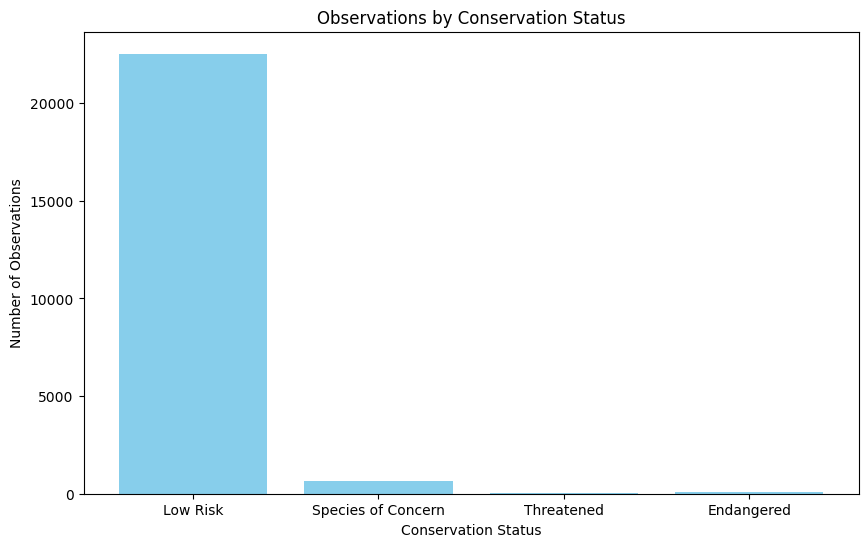

In [30]:
# Count the number of observations per conservation status
status_counts = combined_df['conservation_status'].value_counts().reindex(status_order)

# Create a bar chart for conservation status
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values, color='skyblue')
plt.title("Observations by Conservation Status")
plt.xlabel("Conservation Status")
plt.ylabel("Number of Observations")
plt.show()


## Identifying the Number of Species in Each Category

Now, let's analyze the dataset to determine how many species belong to each category (e.g., Mammal, Bird, Reptile, etc.). This helps in understanding species diversity.

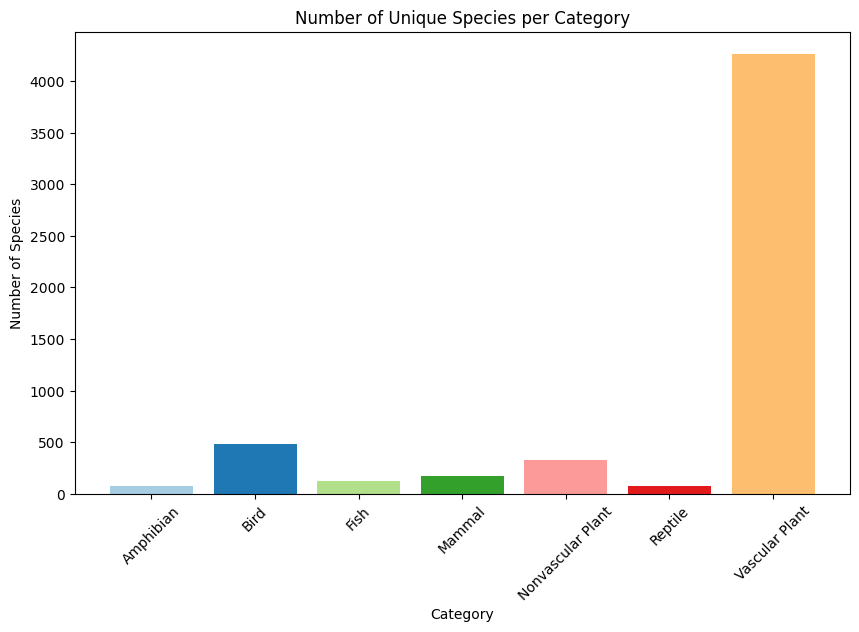

In [31]:
# Count unique species per category
category_counts = combined_df.groupby('category')['scientific_name'].nunique()

# Define a unique color for each category
colors = plt.cm.Paired.colors[:len(category_counts)]  # Use a colormap to assign unique colors

# Create a bar chart with different colors for each category
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.title("Number of Unique Species per Category")
plt.xlabel("Category")
plt.ylabel("Number of Species")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.show()


## Identifying the Most Frequently Observed Endangered Species

let's filter the dataset to focus on endangered species and find the ones with the highest number of observations.

In [32]:
# Filter the dataset to include only endangered species
endangered_species = combined_df[combined_df['conservation_status'] == 'Endangered']

# Group by species and sum the total observations
endangered_counts = endangered_species.groupby('common_names')['observations'].sum()

# Sort values in descending order to find the most frequently observed endangered species
endangered_counts = endangered_counts.sort_values(ascending=False)

# Display the top 10 most observed endangered species
print(endangered_counts.head(10))


common_names
Gray Wolf, Wolf                                                715
Duskytail Darter                                               166
Mountain Avens, Spreading Avens                                162
Gray Myotis                                                    160
California Condor                                              156
Carolina Northern Flying Squirrel, Northern Flying Squirrel    153
Sierra Nevada Bighorn Sheep                                    153
June Sucker                                                    146
Red-Cockaded Woodpecker                                        146
Indiana Bat, Indiana Or Social Myotis                          145
Name: observations, dtype: int64


## Visualizing the Most Frequently Observed Endangered Species

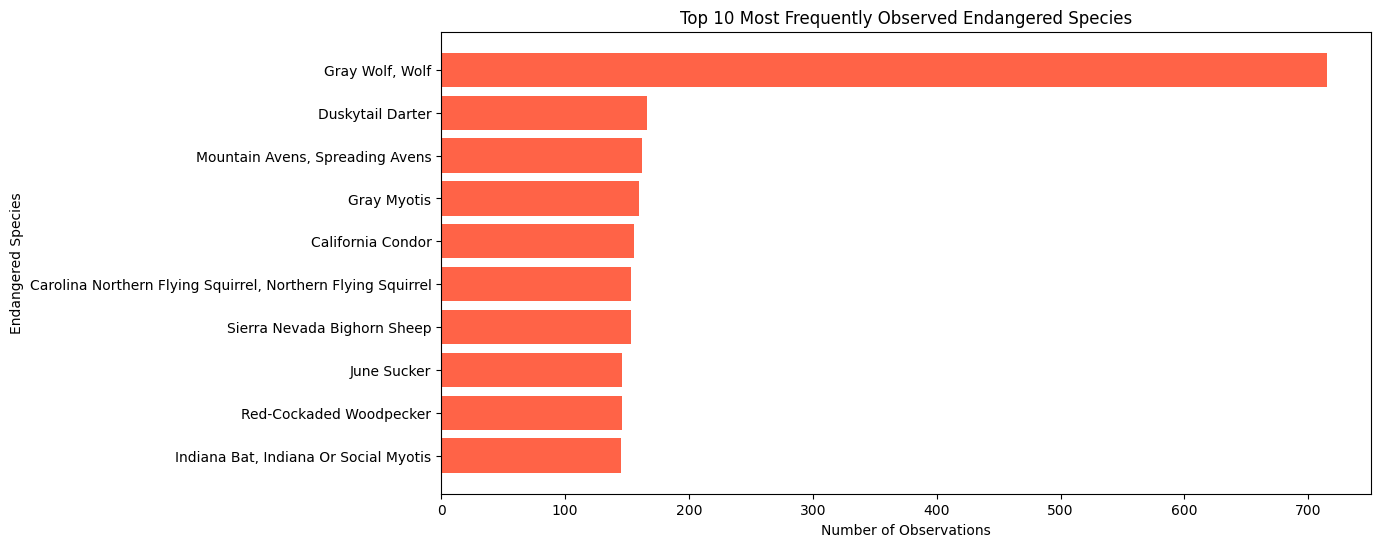

In [33]:
# Select the top 10 most observed endangered species
top_endangered = endangered_counts.head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_endangered.index, top_endangered.values, color='tomato')  # Horizontal bar chart for readability
plt.xlabel("Number of Observations")
plt.ylabel("Endangered Species")
plt.title("Top 10 Most Frequently Observed Endangered Species")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest at the top
plt.show()


## Comparing the Number of Endangered Species Across Categories

Now, let's analyze which categories (e.g., Mammals, Birds, etc.) have the highest number of endangered species.

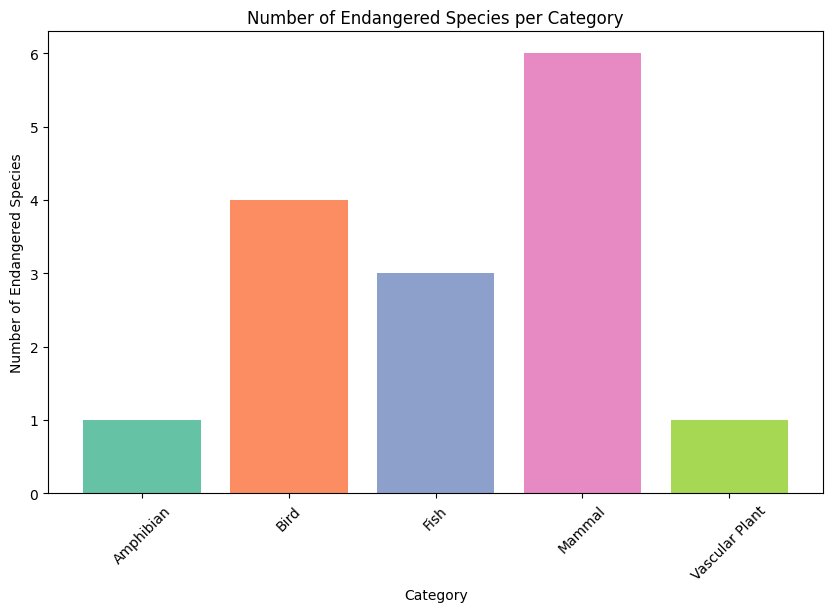

In [34]:
# Count the number of endangered species per category
endangered_by_category = endangered_species.groupby('category')['scientific_name'].nunique()

# Create a bar chart to visualize the number of endangered species in each category
plt.figure(figsize=(10, 6))
plt.bar(endangered_by_category.index, endangered_by_category.values, color=plt.cm.Set2.colors)
plt.title("Number of Endangered Species per Category")
plt.xlabel("Category")
plt.ylabel("Number of Endangered Species")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


## Analyzing the Relationship Between Bird Type and Conservation Status

Next, let's investigate whether there is a significant relationship between bird type (hawk or sparrow) and their conservation status. we will need to create a contingency table and perform a Chi-square test to check for statistical significance.

In [35]:
from scipy.stats import chi2_contingency

# Filter the dataset for birds only
bird_species = combined_df[combined_df['category'] == 'Bird']

# Focus on hawks and sparrows
hawks_sparrows = bird_species[bird_species['common_names'].str.contains('Hawk|Sparrow', regex=True, na=False)]

# Create a contingency table for conservation status (Low Risk vs. Species of Concern)
contingency_table = pd.crosstab(
    hawks_sparrows['common_names'].str.contains('Hawk'), 
    hawks_sparrows['conservation_status'].isin(['Species of Concern'])
)

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-squared value:", chi2)
print("P-value:", p)

# Interpret results
alpha = 0.05
if p < alpha:
    print("The relationship between bird type (hawk/sparrow) and conservation status is statistically significant.")
else:
    print("No significant relationship found between bird type and conservation status.")


Chi-squared value: 17.3242013321195
P-value: 3.151475853051437e-05
The relationship between bird type (hawk/sparrow) and conservation status is statistically significant.


## Identifying the Best Locations for Observing Endangered Hawks and Sparrows

Let's analyze which national park has the most observations of endangered hawks and sparrows.

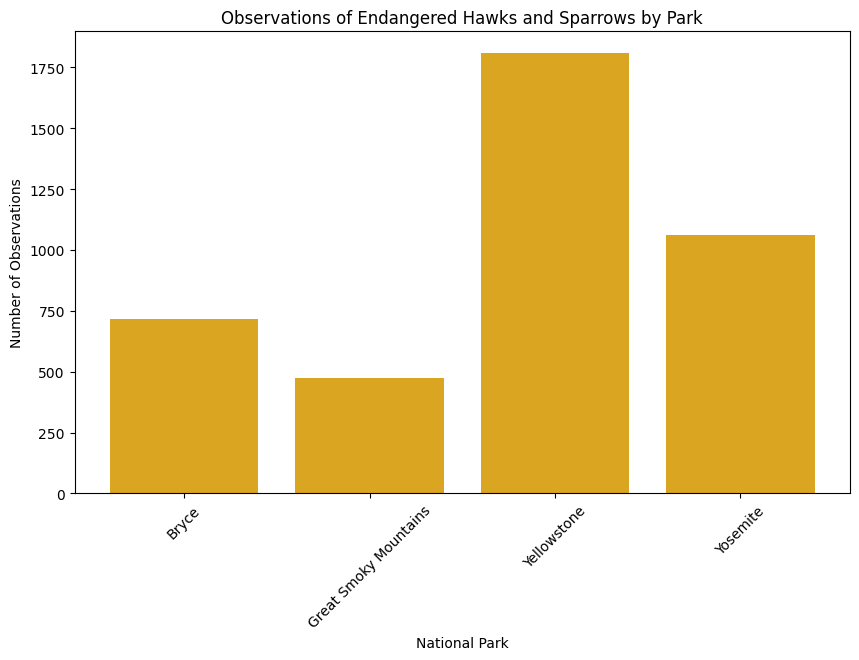

In [36]:
# Filter for endangered hawks and sparrows
endangered_hawks_sparrows = hawks_sparrows[hawks_sparrows['conservation_status'] == 'Species of Concern']

# Group by park and sum the number of observations
observations_by_park = endangered_hawks_sparrows.groupby('park_name')['observations'].sum()

# Create a bar chart to visualize observations by park
plt.figure(figsize=(10, 6))
plt.bar(observations_by_park.index, observations_by_park.values, color='goldenrod')
plt.title("Observations of Endangered Hawks and Sparrows by Park")
plt.xlabel("National Park")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45)  # Rotate labels for clarity
plt.show()


# Summarizing Key Findings and Insights

from our data we can conclude the following:

    1. The dataset includes a variety of species, with vascular plants and birds being the most common categories.
    2. The majority of species are classified as 'Low Risk,' but some fall under 'Species of Concern' or 'Endangered'.
    3. The most frequently observed endangered species include bats, badgers, warblers, and wolves.
    4. Mammals, birds, and vascular plants have the highest number of endangered species, requiring conservation efforts.
    5. Statistical analysis indicates a significant relationship between bird type (hawk/sparrow) and conservation status.
    6. Observations of endangered hawks and sparrows are fairly evenly distributed across all parks, suggesting a potentially artificial dataset.
